# I. Intro to XGboost


In [1]:
import gc
import os
import math
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, roc_curve
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import xgboost as xgb # Change here
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
import seaborn as sns

## Quick Data Treatment

In [2]:
df = pd.read_csv('data/titanic.csv')

In [9]:
y = df['Survived']
X = df.copy()
X = X.drop(columns = ['Survived', 'Name'])
X.Sex = X.Sex.replace("male", 1)
X.Sex = X.Sex.replace("female", 2)

X["family_size"] = X["Siblings/Spouses Aboard"] + X["Parents/Children Aboard"]
X["single"] = (X["family_size"] == 0) * 1.0
X["elder"] =(X["Age"] > 60) * 1.0

Normalize the data X (optional)

In [10]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [11]:
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=20)

This function is to show which featuree is important

In [12]:
def plot_feature_importance(feature_importance,title):
    fe = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)
    fe['feature'] = fe.index
    plt.figure(figsize=(16, 12))
    sns.barplot(x="importance", y="feature", data=fe)
    plt.xticks([])
    plt.title(title)
    return

In [13]:
def train_xgb(X_train, X_valid, y_train, y_valid, params=None):

    model = xgb.XGBClassifier(**params) # Change here
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=['auc', 'logloss'], # Change here
            verbose=1, early_stopping_rounds=50)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)

    importance = pd.DataFrame()
    importance["feature"] = X.columns
    importance["importance"] = model.feature_importances_
    return y_pred_train, y_pred_valid, importance

List of xgboost parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

In [14]:
params = { # Change here
          'n_estimators':5000,
          'max_depth': 4,
          'learning_rate': 0.02,
          'min_child_weight': 2, 
          'gamma': 0, 
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          "booster": "gbtree",
          'nthread': 8,
          'objective': 'binary:logistic',
         }

In [15]:
y_pred_train, y_pred_test, feature_importance = train_xgb(X_scaled_train, X_scaled_test, y_train, y_test, params=params) # Change here

[0]	validation_0-auc:0.855411	validation_0-logloss:0.683717	validation_1-auc:0.800718	validation_1-logloss:0.685088
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[1]	validation_0-auc:0.880424	validation_0-logloss:0.674601	validation_1-auc:0.839791	validation_1-logloss:0.677025
[2]	validation_0-auc:0.883842	validation_0-logloss:0.665725	validation_1-auc:0.833138	validation_1-logloss:0.670063
[3]	validation_0-auc:0.888979	validation_0-logloss:0.658021	validation_1-auc:0.844749	validation_1-logloss:0.662565
[4]	validation_0-auc:0.893102	validation_0-logloss:0.650132	validation_1-auc:0.841422	validation_1-logloss:0.655831
[5]	validation_0-auc:0.891876	validation_0-logloss:0.641965	validation_1-auc:0.837769	validation_1-logloss:0.649199
[6]	validation_0-auc:0.892886	validation_0-logloss:0.634551	validation_1-auc:0.832681	validation_1-logloss:0.643114
[7]	validation_0-auc:0.

[69]	validation_0-auc:0.910396	validation_0-logloss:0.426667	validation_1-auc:0.847162	validation_1-logloss:0.481756
[70]	validation_0-auc:0.91043	validation_0-logloss:0.425821	validation_1-auc:0.848076	validation_1-logloss:0.481135
[71]	validation_0-auc:0.91081	validation_0-logloss:0.424563	validation_1-auc:0.847815	validation_1-logloss:0.480658
[72]	validation_0-auc:0.910793	validation_0-logloss:0.422824	validation_1-auc:0.847684	validation_1-logloss:0.479525
[73]	validation_0-auc:0.91076	validation_0-logloss:0.421175	validation_1-auc:0.847945	validation_1-logloss:0.478562
[74]	validation_0-auc:0.911174	validation_0-logloss:0.419476	validation_1-auc:0.847945	validation_1-logloss:0.477391
[75]	validation_0-auc:0.912002	validation_0-logloss:0.418341	validation_1-auc:0.849119	validation_1-logloss:0.476589
[76]	validation_0-auc:0.912133	validation_0-logloss:0.417606	validation_1-auc:0.847945	validation_1-logloss:0.476508
[77]	validation_0-auc:0.912369	validation_0-logloss:0.416505	valida

[139]	validation_0-auc:0.920188	validation_0-logloss:0.36346	validation_1-auc:0.850163	validation_1-logloss:0.447609
[140]	validation_0-auc:0.920281	validation_0-logloss:0.363059	validation_1-auc:0.84938	validation_1-logloss:0.447599
[141]	validation_0-auc:0.920374	validation_0-logloss:0.362393	validation_1-auc:0.850294	validation_1-logloss:0.44694
[142]	validation_0-auc:0.920678	validation_0-logloss:0.361845	validation_1-auc:0.850685	validation_1-logloss:0.446846
[143]	validation_0-auc:0.920628	validation_0-logloss:0.361211	validation_1-auc:0.850294	validation_1-logloss:0.446484
[144]	validation_0-auc:0.920535	validation_0-logloss:0.36067	validation_1-auc:0.850685	validation_1-logloss:0.44647
[145]	validation_0-auc:0.920611	validation_0-logloss:0.359989	validation_1-auc:0.850685	validation_1-logloss:0.44644
[146]	validation_0-auc:0.920864	validation_0-logloss:0.359501	validation_1-auc:0.850424	validation_1-logloss:0.446473
[147]	validation_0-auc:0.920966	validation_0-logloss:0.359118	

[209]	validation_0-auc:0.929013	validation_0-logloss:0.334939	validation_1-auc:0.851337	validation_1-logloss:0.439975
[210]	validation_0-auc:0.929055	validation_0-logloss:0.334675	validation_1-auc:0.851207	validation_1-logloss:0.439965
[211]	validation_0-auc:0.928912	validation_0-logloss:0.334291	validation_1-auc:0.851076	validation_1-logloss:0.440114
[212]	validation_0-auc:0.929013	validation_0-logloss:0.333979	validation_1-auc:0.851598	validation_1-logloss:0.440049
[213]	validation_0-auc:0.929165	validation_0-logloss:0.333563	validation_1-auc:0.851337	validation_1-logloss:0.440013
[214]	validation_0-auc:0.929165	validation_0-logloss:0.333157	validation_1-auc:0.851598	validation_1-logloss:0.439664
[215]	validation_0-auc:0.929123	validation_0-logloss:0.332804	validation_1-auc:0.851859	validation_1-logloss:0.439538
[216]	validation_0-auc:0.929402	validation_0-logloss:0.332374	validation_1-auc:0.851468	validation_1-logloss:0.439516
[217]	validation_0-auc:0.929436	validation_0-logloss:0.3

[279]	validation_0-auc:0.93513	validation_0-logloss:0.315554	validation_1-auc:0.853816	validation_1-logloss:0.438706
[280]	validation_0-auc:0.935181	validation_0-logloss:0.315359	validation_1-auc:0.853816	validation_1-logloss:0.43871
[281]	validation_0-auc:0.935265	validation_0-logloss:0.315255	validation_1-auc:0.853947	validation_1-logloss:0.438706
[282]	validation_0-auc:0.935367	validation_0-logloss:0.315034	validation_1-auc:0.853555	validation_1-logloss:0.438827
[283]	validation_0-auc:0.935713	validation_0-logloss:0.314684	validation_1-auc:0.853686	validation_1-logloss:0.438613
[284]	validation_0-auc:0.935857	validation_0-logloss:0.314445	validation_1-auc:0.853686	validation_1-logloss:0.438838
[285]	validation_0-auc:0.935975	validation_0-logloss:0.314283	validation_1-auc:0.853686	validation_1-logloss:0.438607
[286]	validation_0-auc:0.936	validation_0-logloss:0.314068	validation_1-auc:0.853425	validation_1-logloss:0.438637
[287]	validation_0-auc:0.936161	validation_0-logloss:0.313828

[349]	validation_0-auc:0.942092	validation_0-logloss:0.300147	validation_1-auc:0.856947	validation_1-logloss:0.437144
[350]	validation_0-auc:0.94221	validation_0-logloss:0.299842	validation_1-auc:0.857339	validation_1-logloss:0.436862
[351]	validation_0-auc:0.942269	validation_0-logloss:0.299683	validation_1-auc:0.857339	validation_1-logloss:0.436882
[352]	validation_0-auc:0.942396	validation_0-logloss:0.299599	validation_1-auc:0.857078	validation_1-logloss:0.43689
[353]	validation_0-auc:0.942548	validation_0-logloss:0.299401	validation_1-auc:0.857208	validation_1-logloss:0.436961
[354]	validation_0-auc:0.942641	validation_0-logloss:0.299234	validation_1-auc:0.857469	validation_1-logloss:0.43703
[355]	validation_0-auc:0.942573	validation_0-logloss:0.299056	validation_1-auc:0.857469	validation_1-logloss:0.436939
[356]	validation_0-auc:0.942616	validation_0-logloss:0.298897	validation_1-auc:0.857469	validation_1-logloss:0.436974
[357]	validation_0-auc:0.942675	validation_0-logloss:0.2987

In [16]:
train_acc = sum(y_train == y_pred_train)/len(y_train)
train_acc

0.8942172073342737

In [17]:
test_acc = sum(y_test == y_pred_test)/len(y_test)
test_acc

0.8202247191011236

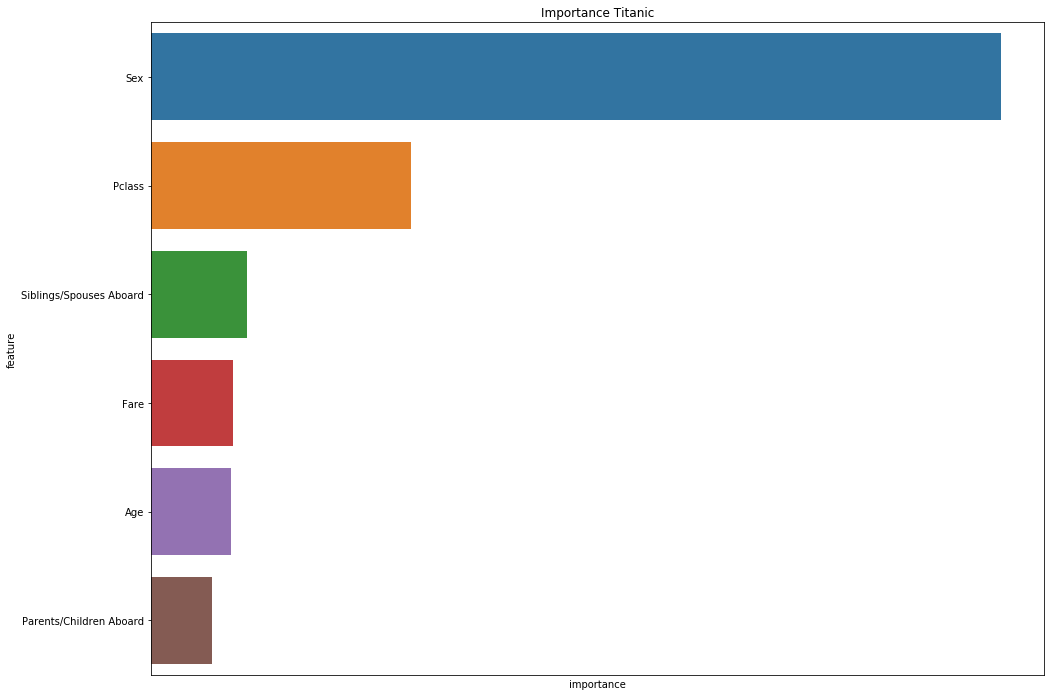

In [18]:
plot_feature_importance(feature_importance, title = 'Importance Titanic')

**Exercise:** Retrain without rescale X to see anything different

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
y_pred_train, y_pred_test, feature_importance = train_xgb(X_train, X_test, y_train, y_test, params=params)

[0]	validation_0-auc:0.855411	validation_0-logloss:0.683717	validation_1-auc:0.800718	validation_1-logloss:0.685088
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[1]	validation_0-auc:0.880424	validation_0-logloss:0.674601	validation_1-auc:0.839791	validation_1-logloss:0.677025
[2]	validation_0-auc:0.883842	validation_0-logloss:0.665725	validation_1-auc:0.833138	validation_1-logloss:0.670063
[3]	validation_0-auc:0.888979	validation_0-logloss:0.658021	validation_1-auc:0.844749	validation_1-logloss:0.662565
[4]	validation_0-auc:0.893102	validation_0-logloss:0.650132	validation_1-auc:0.841422	validation_1-logloss:0.655831
[5]	validation_0-auc:0.891876	validation_0-logloss:0.641965	validation_1-auc:0.837769	validation_1-logloss:0.649199
[6]	validation_0-auc:0.892886	validation_0-logloss:0.634551	validation_1-auc:0.832681	validation_1-logloss:0.643114
[7]	validation_0-auc:0.

[69]	validation_0-auc:0.910396	validation_0-logloss:0.426667	validation_1-auc:0.847358	validation_1-logloss:0.481745
[70]	validation_0-auc:0.91043	validation_0-logloss:0.425821	validation_1-auc:0.848271	validation_1-logloss:0.481124
[71]	validation_0-auc:0.91081	validation_0-logloss:0.424563	validation_1-auc:0.84801	validation_1-logloss:0.480647
[72]	validation_0-auc:0.910793	validation_0-logloss:0.422824	validation_1-auc:0.84788	validation_1-logloss:0.479514
[73]	validation_0-auc:0.91076	validation_0-logloss:0.421175	validation_1-auc:0.848141	validation_1-logloss:0.478543
[74]	validation_0-auc:0.911174	validation_0-logloss:0.419476	validation_1-auc:0.848271	validation_1-logloss:0.477372
[75]	validation_0-auc:0.912002	validation_0-logloss:0.418341	validation_1-auc:0.849576	validation_1-logloss:0.476561
[76]	validation_0-auc:0.912133	validation_0-logloss:0.417606	validation_1-auc:0.848402	validation_1-logloss:0.476481
[77]	validation_0-auc:0.912369	validation_0-logloss:0.416505	validati

[139]	validation_0-auc:0.920188	validation_0-logloss:0.36346	validation_1-auc:0.85062	validation_1-logloss:0.447545
[140]	validation_0-auc:0.920281	validation_0-logloss:0.363059	validation_1-auc:0.849837	validation_1-logloss:0.447536
[141]	validation_0-auc:0.920374	validation_0-logloss:0.362393	validation_1-auc:0.85075	validation_1-logloss:0.446871
[142]	validation_0-auc:0.920678	validation_0-logloss:0.361845	validation_1-auc:0.851142	validation_1-logloss:0.446777
[143]	validation_0-auc:0.920628	validation_0-logloss:0.361211	validation_1-auc:0.85075	validation_1-logloss:0.446415
[144]	validation_0-auc:0.920535	validation_0-logloss:0.36067	validation_1-auc:0.851142	validation_1-logloss:0.446403
[145]	validation_0-auc:0.920611	validation_0-logloss:0.359989	validation_1-auc:0.851142	validation_1-logloss:0.446373
[146]	validation_0-auc:0.920864	validation_0-logloss:0.359501	validation_1-auc:0.850881	validation_1-logloss:0.446407
[147]	validation_0-auc:0.920966	validation_0-logloss:0.359118

[209]	validation_0-auc:0.929005	validation_0-logloss:0.334932	validation_1-auc:0.851729	validation_1-logloss:0.439862
[210]	validation_0-auc:0.929047	validation_0-logloss:0.334668	validation_1-auc:0.851598	validation_1-logloss:0.439853
[211]	validation_0-auc:0.928912	validation_0-logloss:0.334283	validation_1-auc:0.851468	validation_1-logloss:0.440004
[212]	validation_0-auc:0.929013	validation_0-logloss:0.333972	validation_1-auc:0.85199	validation_1-logloss:0.439939
[213]	validation_0-auc:0.929165	validation_0-logloss:0.333555	validation_1-auc:0.851729	validation_1-logloss:0.439904
[214]	validation_0-auc:0.929165	validation_0-logloss:0.33315	validation_1-auc:0.85199	validation_1-logloss:0.439555
[215]	validation_0-auc:0.929123	validation_0-logloss:0.332797	validation_1-auc:0.852251	validation_1-logloss:0.43943
[216]	validation_0-auc:0.929402	validation_0-logloss:0.332367	validation_1-auc:0.851859	validation_1-logloss:0.439407
[217]	validation_0-auc:0.929444	validation_0-logloss:0.33221

[279]	validation_0-auc:0.935122	validation_0-logloss:0.315547	validation_1-auc:0.854207	validation_1-logloss:0.438545
[280]	validation_0-auc:0.935181	validation_0-logloss:0.315353	validation_1-auc:0.854207	validation_1-logloss:0.438549
[281]	validation_0-auc:0.935265	validation_0-logloss:0.315249	validation_1-auc:0.854338	validation_1-logloss:0.438546
[282]	validation_0-auc:0.935367	validation_0-logloss:0.315028	validation_1-auc:0.853947	validation_1-logloss:0.438667
[283]	validation_0-auc:0.935722	validation_0-logloss:0.314678	validation_1-auc:0.854077	validation_1-logloss:0.438455
[284]	validation_0-auc:0.935865	validation_0-logloss:0.314439	validation_1-auc:0.854077	validation_1-logloss:0.438677
[285]	validation_0-auc:0.935983	validation_0-logloss:0.314277	validation_1-auc:0.854077	validation_1-logloss:0.438446
[286]	validation_0-auc:0.936	validation_0-logloss:0.314062	validation_1-auc:0.853816	validation_1-logloss:0.438476
[287]	validation_0-auc:0.936144	validation_0-logloss:0.3138

[349]	validation_0-auc:0.942092	validation_0-logloss:0.300141	validation_1-auc:0.857469	validation_1-logloss:0.436941
[350]	validation_0-auc:0.942219	validation_0-logloss:0.299836	validation_1-auc:0.85786	validation_1-logloss:0.43666
[351]	validation_0-auc:0.942278	validation_0-logloss:0.299677	validation_1-auc:0.85786	validation_1-logloss:0.43668
[352]	validation_0-auc:0.942396	validation_0-logloss:0.299593	validation_1-auc:0.857599	validation_1-logloss:0.436687
[353]	validation_0-auc:0.942548	validation_0-logloss:0.299396	validation_1-auc:0.85773	validation_1-logloss:0.436759
[354]	validation_0-auc:0.942641	validation_0-logloss:0.299228	validation_1-auc:0.857991	validation_1-logloss:0.436829
[355]	validation_0-auc:0.942565	validation_0-logloss:0.299051	validation_1-auc:0.857991	validation_1-logloss:0.436738
[356]	validation_0-auc:0.942624	validation_0-logloss:0.298891	validation_1-auc:0.857991	validation_1-logloss:0.436773
[357]	validation_0-auc:0.942675	validation_0-logloss:0.298701

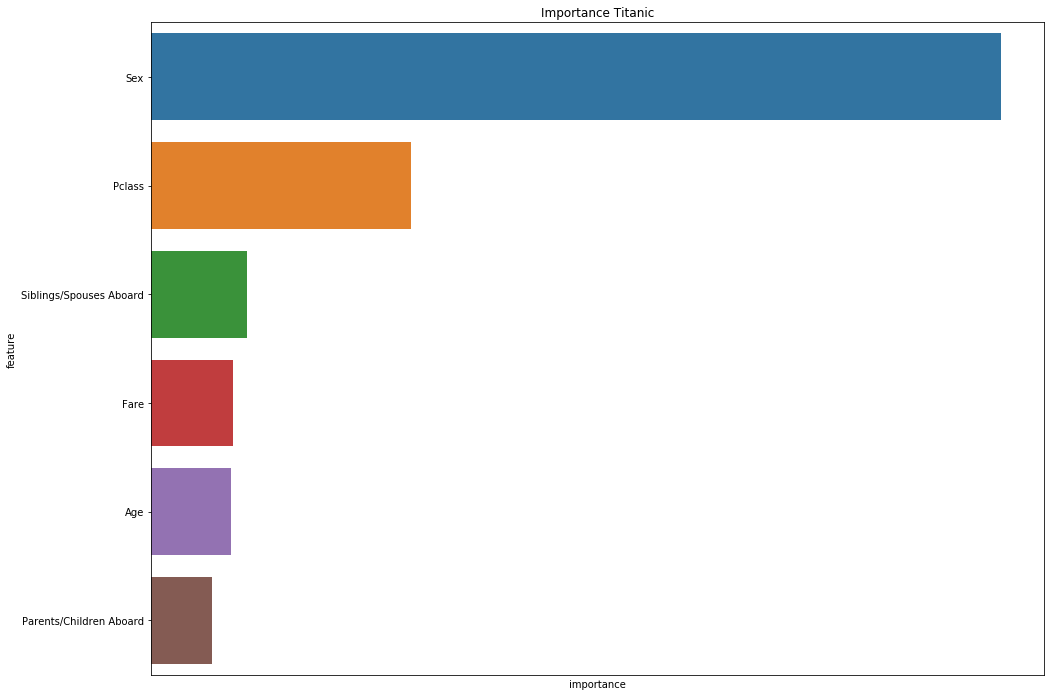

In [22]:
plot_feature_importance(feature_importance, title = 'Importance Titanic')

**Exercise:** Try tuning, adding, removing params.
    
See https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [25]:
params = { # Change here
          'n_estimators':500,
          'max_depth': 4,
          'learning_rate': 0.001,
          'min_child_weight': 2, 
          'gamma': 0, 
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          "booster": "gbtree",
          'nthread': 8,
          'objective': 'binary:logistic',
          "boosting": "gbdt",
          "bagging_freq": 10,
          "bagging_fraction": 0.7,
          "bagging_seed": 11,
         }

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
y_pred_train, y_pred_test, feature_importance = train_xgb(X_train, X_test, y_train, y_test, params=params)

[0]	validation_0-auc:0.855411	validation_0-logloss:0.692671	validation_1-auc:0.800718	validation_1-logloss:0.69274
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[1]	validation_0-auc:0.880424	validation_0-logloss:0.692195	validation_1-auc:0.839791	validation_1-logloss:0.692318
[2]	validation_0-auc:0.881522	validation_0-logloss:0.691716	validation_1-auc:0.834768	validation_1-logloss:0.691919
[3]	validation_0-auc:0.887918	validation_0-logloss:0.691287	validation_1-auc:0.84501	validation_1-logloss:0.691504
[4]	validation_0-auc:0.891796	validation_0-logloss:0.690831	validation_1-auc:0.841292	validation_1-logloss:0.691111
[5]	validation_0-auc:0.891441	validation_0-logloss:0.690345	validation_1-auc:0.838421	validation_1-logloss:0.69071
[6]	validation_0-auc:0.891391	validation_0-logloss:0.689884	validation_1-auc:0.836008	validation_1-logloss:0.690316
[7]	validation_0-auc:0.891

[69]	validation_0-auc:0.90515	validation_0-logloss:0.665639	validation_1-auc:0.845532	validation_1-logloss:0.670154
[70]	validation_0-auc:0.905509	validation_0-logloss:0.665417	validation_1-auc:0.845271	validation_1-logloss:0.669971
[71]	validation_0-auc:0.905804	validation_0-logloss:0.665144	validation_1-auc:0.845597	validation_1-logloss:0.669817
[72]	validation_0-auc:0.905652	validation_0-logloss:0.664726	validation_1-auc:0.845597	validation_1-logloss:0.669461
[73]	validation_0-auc:0.905585	validation_0-logloss:0.664351	validation_1-auc:0.845336	validation_1-logloss:0.669125
[74]	validation_0-auc:0.905602	validation_0-logloss:0.663935	validation_1-auc:0.845075	validation_1-logloss:0.668787
[75]	validation_0-auc:0.905813	validation_0-logloss:0.663676	validation_1-auc:0.845466	validation_1-logloss:0.668613
[76]	validation_0-auc:0.905956	validation_0-logloss:0.663439	validation_1-auc:0.845336	validation_1-logloss:0.66846
[77]	validation_0-auc:0.906311	validation_0-logloss:0.663182	valid

[139]	validation_0-auc:0.907266	validation_0-logloss:0.642398	validation_1-auc:0.849967	validation_1-logloss:0.651102
[140]	validation_0-auc:0.907367	validation_0-logloss:0.64217	validation_1-auc:0.849967	validation_1-logloss:0.650943
[141]	validation_0-auc:0.907367	validation_0-logloss:0.641744	validation_1-auc:0.850359	validation_1-logloss:0.650573
[142]	validation_0-auc:0.907426	validation_0-logloss:0.641537	validation_1-auc:0.849706	validation_1-logloss:0.650429
[143]	validation_0-auc:0.907511	validation_0-logloss:0.641116	validation_1-auc:0.850098	validation_1-logloss:0.65006
[144]	validation_0-auc:0.907274	validation_0-logloss:0.640783	validation_1-auc:0.851402	validation_1-logloss:0.649739
[145]	validation_0-auc:0.907127	validation_0-logloss:0.640441	validation_1-auc:0.851011	validation_1-logloss:0.649454
[146]	validation_0-auc:0.907287	validation_0-logloss:0.640222	validation_1-auc:0.85062	validation_1-logloss:0.64928
[147]	validation_0-auc:0.907169	validation_0-logloss:0.64000

[209]	validation_0-auc:0.907684	validation_0-logloss:0.620681	validation_1-auc:0.851272	validation_1-logloss:0.633305
[210]	validation_0-auc:0.907667	validation_0-logloss:0.620365	validation_1-auc:0.851402	validation_1-logloss:0.633043
[211]	validation_0-auc:0.907811	validation_0-logloss:0.620144	validation_1-auc:0.851142	validation_1-logloss:0.632924
[212]	validation_0-auc:0.907786	validation_0-logloss:0.619781	validation_1-auc:0.851011	validation_1-logloss:0.632627
[213]	validation_0-auc:0.90771	validation_0-logloss:0.61947	validation_1-auc:0.850881	validation_1-logloss:0.632364
[214]	validation_0-auc:0.907667	validation_0-logloss:0.619081	validation_1-auc:0.851142	validation_1-logloss:0.632011
[215]	validation_0-auc:0.907718	validation_0-logloss:0.618701	validation_1-auc:0.851402	validation_1-logloss:0.631674
[216]	validation_0-auc:0.907718	validation_0-logloss:0.61832	validation_1-auc:0.851272	validation_1-logloss:0.631377
[217]	validation_0-auc:0.907769	validation_0-logloss:0.6181

[279]	validation_0-auc:0.907249	validation_0-logloss:0.60041	validation_1-auc:0.851402	validation_1-logloss:0.616817
[280]	validation_0-auc:0.907266	validation_0-logloss:0.600074	validation_1-auc:0.851402	validation_1-logloss:0.616522
[281]	validation_0-auc:0.907384	validation_0-logloss:0.599897	validation_1-auc:0.851142	validation_1-logloss:0.616394
[282]	validation_0-auc:0.907334	validation_0-logloss:0.599585	validation_1-auc:0.851142	validation_1-logloss:0.616158
[283]	validation_0-auc:0.907342	validation_0-logloss:0.599249	validation_1-auc:0.851142	validation_1-logloss:0.615851
[284]	validation_0-auc:0.907393	validation_0-logloss:0.599066	validation_1-auc:0.851142	validation_1-logloss:0.615724
[285]	validation_0-auc:0.907519	validation_0-logloss:0.598868	validation_1-auc:0.850881	validation_1-logloss:0.615624
[286]	validation_0-auc:0.907519	validation_0-logloss:0.598529	validation_1-auc:0.850881	validation_1-logloss:0.615346
[287]	validation_0-auc:0.907469	validation_0-logloss:0.59

[349]	validation_0-auc:0.907811	validation_0-logloss:0.582141	validation_1-auc:0.85075	validation_1-logloss:0.602125
[350]	validation_0-auc:0.90771	validation_0-logloss:0.581876	validation_1-auc:0.85075	validation_1-logloss:0.601873
[351]	validation_0-auc:0.90787	validation_0-logloss:0.581686	validation_1-auc:0.85075	validation_1-logloss:0.601781
[352]	validation_0-auc:0.907938	validation_0-logloss:0.581401	validation_1-auc:0.851011	validation_1-logloss:0.601544
[353]	validation_0-auc:0.907845	validation_0-logloss:0.581157	validation_1-auc:0.850881	validation_1-logloss:0.601321
[354]	validation_0-auc:0.907802	validation_0-logloss:0.580858	validation_1-auc:0.85075	validation_1-logloss:0.601087
[355]	validation_0-auc:0.907904	validation_0-logloss:0.580704	validation_1-auc:0.850489	validation_1-logloss:0.600972
[356]	validation_0-auc:0.907895	validation_0-logloss:0.580561	validation_1-auc:0.850881	validation_1-logloss:0.600883
[357]	validation_0-auc:0.907895	validation_0-logloss:0.580275	

[419]	validation_0-auc:0.908094	validation_0-logloss:0.566098	validation_1-auc:0.850098	validation_1-logloss:0.589213
[420]	validation_0-auc:0.908136	validation_0-logloss:0.565817	validation_1-auc:0.850359	validation_1-logloss:0.588971
[421]	validation_0-auc:0.908035	validation_0-logloss:0.565554	validation_1-auc:0.850359	validation_1-logloss:0.588753
[422]	validation_0-auc:0.908086	validation_0-logloss:0.565289	validation_1-auc:0.850228	validation_1-logloss:0.588522
[423]	validation_0-auc:0.908009	validation_0-logloss:0.565054	validation_1-auc:0.850359	validation_1-logloss:0.588303
[424]	validation_0-auc:0.908018	validation_0-logloss:0.564761	validation_1-auc:0.850359	validation_1-logloss:0.588081
[425]	validation_0-auc:0.90806	validation_0-logloss:0.564611	validation_1-auc:0.850359	validation_1-logloss:0.58799
[426]	validation_0-auc:0.908077	validation_0-logloss:0.564326	validation_1-auc:0.850228	validation_1-logloss:0.587762
[427]	validation_0-auc:0.908119	validation_0-logloss:0.564

[489]	validation_0-auc:0.908398	validation_0-logloss:0.551	validation_1-auc:0.850228	validation_1-logloss:0.577362
[490]	validation_0-auc:0.908373	validation_0-logloss:0.550763	validation_1-auc:0.850228	validation_1-logloss:0.577163
[491]	validation_0-auc:0.908508	validation_0-logloss:0.550626	validation_1-auc:0.850098	validation_1-logloss:0.577067
[492]	validation_0-auc:0.908533	validation_0-logloss:0.550491	validation_1-auc:0.849967	validation_1-logloss:0.576993
[493]	validation_0-auc:0.908533	validation_0-logloss:0.550373	validation_1-auc:0.849967	validation_1-logloss:0.576948
[494]	validation_0-auc:0.908542	validation_0-logloss:0.550117	validation_1-auc:0.849967	validation_1-logloss:0.576733
[495]	validation_0-auc:0.908533	validation_0-logloss:0.549861	validation_1-auc:0.849967	validation_1-logloss:0.576536
[496]	validation_0-auc:0.908474	validation_0-logloss:0.54963	validation_1-auc:0.849967	validation_1-logloss:0.576333
[497]	validation_0-auc:0.908483	validation_0-logloss:0.54950

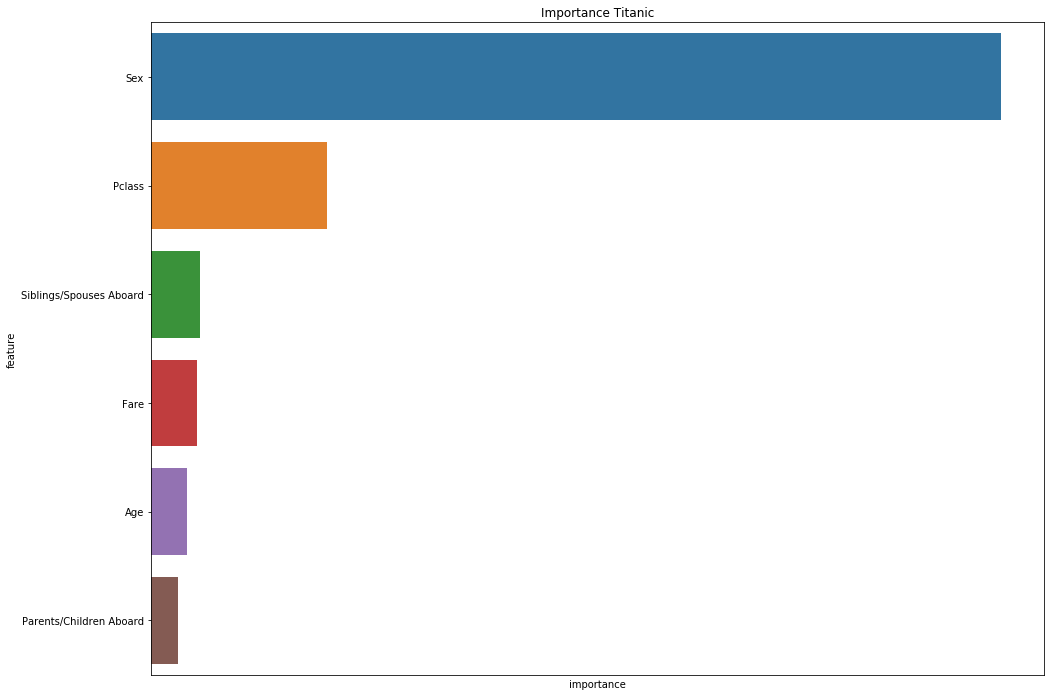

In [27]:
plot_feature_importance(feature_importance, title = 'Importance Titanic')

**Exercise:** Try creating new features, or removing unimportant features

In [33]:
y = df.Survived
X = df.copy()

X.Sex = X.Sex.replace("male", 1)
X.Sex = X.Sex.replace("female", 2)

X["elder"] =(X["Age"] > 60) * 1.0
X["child"] = (X["Age"] < 18) * 1.0
X["family_size"] = X["Siblings/Spouses Aboard"] + X["Parents/Children Aboard"]
X["single"] = (X["family_size"] == 0) * 1.0
X = X.drop(columns=["Name", "Age", "Fare", "Survived"])

In [34]:
X.columns

Index(['Pclass', 'Sex', 'Siblings/Spouses Aboard', 'Parents/Children Aboard',
       'elder', 'child', 'family_size', 'single'],
      dtype='object')

In [ ]:
params = { # Change here
          'n_estimators':500,
          'max_depth': 4,
          'learning_rate': 0.001,
          'min_child_weight': 2, 
          'gamma': 0, 
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          "booster": "gbtree",
          'nthread': 8,
          'objective': 'binary:logistic',
          "boosting": "gbdt",
          "bagging_freq": 10,
          "bagging_fraction": 0.7,
          "bagging_seed": 11,
         }

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
y_pred_train, y_pred_test, feature_importance = train_xgb(X_train, X_test, y_train, y_test, params=params)

[0]	validation_0-auc:0.866154	validation_0-logloss:0.692663	validation_1-auc:0.845793	validation_1-logloss:0.692699
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[1]	validation_0-auc:0.868216	validation_0-logloss:0.692201	validation_1-auc:0.842401	validation_1-logloss:0.692275
[2]	validation_0-auc:0.870311	validation_0-logloss:0.691738	validation_1-auc:0.835029	validation_1-logloss:0.691882
[3]	validation_0-auc:0.875237	validation_0-logloss:0.691492	validation_1-auc:0.827332	validation_1-logloss:0.691668
[4]	validation_0-auc:0.875503	validation_0-logloss:0.691103	validation_1-auc:0.834377	validation_1-logloss:0.691316
[5]	validation_0-auc:0.87462	validation_0-logloss:0.690682	validation_1-auc:0.834247	validation_1-logloss:0.690906
[6]	validation_0-auc:0.873851	validation_0-logloss:0.690264	validation_1-auc:0.834768	validation_1-logloss:0.690503
[7]	validation_0-auc:0.8

[69]	validation_0-auc:0.87628	validation_0-logloss:0.667764	validation_1-auc:0.833007	validation_1-logloss:0.670307
[70]	validation_0-auc:0.87628	validation_0-logloss:0.667392	validation_1-auc:0.833007	validation_1-logloss:0.669941
[71]	validation_0-auc:0.876466	validation_0-logloss:0.66717	validation_1-auc:0.833268	validation_1-logloss:0.669747
[72]	validation_0-auc:0.876364	validation_0-logloss:0.666745	validation_1-auc:0.833007	validation_1-logloss:0.669353
[73]	validation_0-auc:0.876356	validation_0-logloss:0.666378	validation_1-auc:0.833007	validation_1-logloss:0.668999
[74]	validation_0-auc:0.876466	validation_0-logloss:0.666162	validation_1-auc:0.833268	validation_1-logloss:0.668825
[75]	validation_0-auc:0.876466	validation_0-logloss:0.665761	validation_1-auc:0.833268	validation_1-logloss:0.668468
[76]	validation_0-auc:0.876407	validation_0-logloss:0.665348	validation_1-auc:0.833268	validation_1-logloss:0.668094
[77]	validation_0-auc:0.876474	validation_0-logloss:0.664944	valida

[139]	validation_0-auc:0.876402	validation_0-logloss:0.64454	validation_1-auc:0.833268	validation_1-logloss:0.649458
[140]	validation_0-auc:0.876402	validation_0-logloss:0.644213	validation_1-auc:0.833268	validation_1-logloss:0.649144
[141]	validation_0-auc:0.876732	validation_0-logloss:0.644016	validation_1-auc:0.833399	validation_1-logloss:0.648974
[142]	validation_0-auc:0.876639	validation_0-logloss:0.64365	validation_1-auc:0.833268	validation_1-logloss:0.648635
[143]	validation_0-auc:0.876242	validation_0-logloss:0.643343	validation_1-auc:0.833268	validation_1-logloss:0.648356
[144]	validation_0-auc:0.876386	validation_0-logloss:0.642966	validation_1-auc:0.833268	validation_1-logloss:0.648043
[145]	validation_0-auc:0.876386	validation_0-logloss:0.642633	validation_1-auc:0.833268	validation_1-logloss:0.64772
[146]	validation_0-auc:0.876386	validation_0-logloss:0.642254	validation_1-auc:0.833268	validation_1-logloss:0.647368
[147]	validation_0-auc:0.876386	validation_0-logloss:0.6418

[209]	validation_0-auc:0.876588	validation_0-logloss:0.623339	validation_1-auc:0.832746	validation_1-logloss:0.630725
[210]	validation_0-auc:0.87658	validation_0-logloss:0.623031	validation_1-auc:0.832746	validation_1-logloss:0.630431
[211]	validation_0-auc:0.876571	validation_0-logloss:0.622739	validation_1-auc:0.832746	validation_1-logloss:0.630154
[212]	validation_0-auc:0.87658	validation_0-logloss:0.622429	validation_1-auc:0.832746	validation_1-logloss:0.629862
[213]	validation_0-auc:0.876546	validation_0-logloss:0.622098	validation_1-auc:0.832616	validation_1-logloss:0.629578
[214]	validation_0-auc:0.87658	validation_0-logloss:0.621926	validation_1-auc:0.832746	validation_1-logloss:0.629431
[215]	validation_0-auc:0.876707	validation_0-logloss:0.621755	validation_1-auc:0.832746	validation_1-logloss:0.629281
[216]	validation_0-auc:0.876715	validation_0-logloss:0.621586	validation_1-auc:0.832746	validation_1-logloss:0.629152
[217]	validation_0-auc:0.876715	validation_0-logloss:0.6212

[279]	validation_0-auc:0.876909	validation_0-logloss:0.604574	validation_1-auc:0.832877	validation_1-logloss:0.614086
[280]	validation_0-auc:0.876994	validation_0-logloss:0.60425	validation_1-auc:0.832877	validation_1-logloss:0.613791
[281]	validation_0-auc:0.876842	validation_0-logloss:0.603949	validation_1-auc:0.832746	validation_1-logloss:0.613533
[282]	validation_0-auc:0.876833	validation_0-logloss:0.603693	validation_1-auc:0.832746	validation_1-logloss:0.613304
[283]	validation_0-auc:0.876833	validation_0-logloss:0.603393	validation_1-auc:0.832746	validation_1-logloss:0.613033
[284]	validation_0-auc:0.876808	validation_0-logloss:0.603088	validation_1-auc:0.832616	validation_1-logloss:0.612765
[285]	validation_0-auc:0.876825	validation_0-logloss:0.602929	validation_1-auc:0.832746	validation_1-logloss:0.612639
[286]	validation_0-auc:0.876926	validation_0-logloss:0.602657	validation_1-auc:0.832746	validation_1-logloss:0.612367
[287]	validation_0-auc:0.876926	validation_0-logloss:0.60

[349]	validation_0-auc:0.876994	validation_0-logloss:0.586876	validation_1-auc:0.832746	validation_1-logloss:0.598321
[350]	validation_0-auc:0.876994	validation_0-logloss:0.586632	validation_1-auc:0.832746	validation_1-logloss:0.598086
[351]	validation_0-auc:0.876994	validation_0-logloss:0.586478	validation_1-auc:0.832746	validation_1-logloss:0.597974
[352]	validation_0-auc:0.876994	validation_0-logloss:0.586194	validation_1-auc:0.832746	validation_1-logloss:0.597741
[353]	validation_0-auc:0.877053	validation_0-logloss:0.585916	validation_1-auc:0.832746	validation_1-logloss:0.597504
[354]	validation_0-auc:0.876985	validation_0-logloss:0.58563	validation_1-auc:0.832746	validation_1-logloss:0.597257
[355]	validation_0-auc:0.876985	validation_0-logloss:0.585397	validation_1-auc:0.832746	validation_1-logloss:0.597047
[356]	validation_0-auc:0.876985	validation_0-logloss:0.585122	validation_1-auc:0.832746	validation_1-logloss:0.596816
[357]	validation_0-auc:0.876985	validation_0-logloss:0.58

[419]	validation_0-auc:0.877078	validation_0-logloss:0.571363	validation_1-auc:0.832877	validation_1-logloss:0.584803
[420]	validation_0-auc:0.877087	validation_0-logloss:0.571108	validation_1-auc:0.832877	validation_1-logloss:0.584571
[421]	validation_0-auc:0.877061	validation_0-logloss:0.570861	validation_1-auc:0.832877	validation_1-logloss:0.584363
[422]	validation_0-auc:0.87707	validation_0-logloss:0.570735	validation_1-auc:0.832877	validation_1-logloss:0.584266
[423]	validation_0-auc:0.87707	validation_0-logloss:0.570484	validation_1-auc:0.832877	validation_1-logloss:0.584035
[424]	validation_0-auc:0.877239	validation_0-logloss:0.570238	validation_1-auc:0.832877	validation_1-logloss:0.583833
[425]	validation_0-auc:0.877214	validation_0-logloss:0.569971	validation_1-auc:0.832877	validation_1-logloss:0.583602
[426]	validation_0-auc:0.877171	validation_0-logloss:0.56984	validation_1-auc:0.832877	validation_1-logloss:0.583494
[427]	validation_0-auc:0.877171	validation_0-logloss:0.5695

[489]	validation_0-auc:0.87723	validation_0-logloss:0.556713	validation_1-auc:0.832355	validation_1-logloss:0.572056
[490]	validation_0-auc:0.877399	validation_0-logloss:0.556476	validation_1-auc:0.832355	validation_1-logloss:0.571845
[491]	validation_0-auc:0.877484	validation_0-logloss:0.556271	validation_1-auc:0.832355	validation_1-logloss:0.571645
[492]	validation_0-auc:0.877399	validation_0-logloss:0.556088	validation_1-auc:0.833007	validation_1-logloss:0.571478
[493]	validation_0-auc:0.877399	validation_0-logloss:0.555907	validation_1-auc:0.833007	validation_1-logloss:0.571312
[494]	validation_0-auc:0.877391	validation_0-logloss:0.555681	validation_1-auc:0.833007	validation_1-logloss:0.571111
[495]	validation_0-auc:0.877374	validation_0-logloss:0.555446	validation_1-auc:0.833007	validation_1-logloss:0.570907
[496]	validation_0-auc:0.877171	validation_0-logloss:0.555262	validation_1-auc:0.833007	validation_1-logloss:0.570744
[497]	validation_0-auc:0.87718	validation_0-logloss:0.555

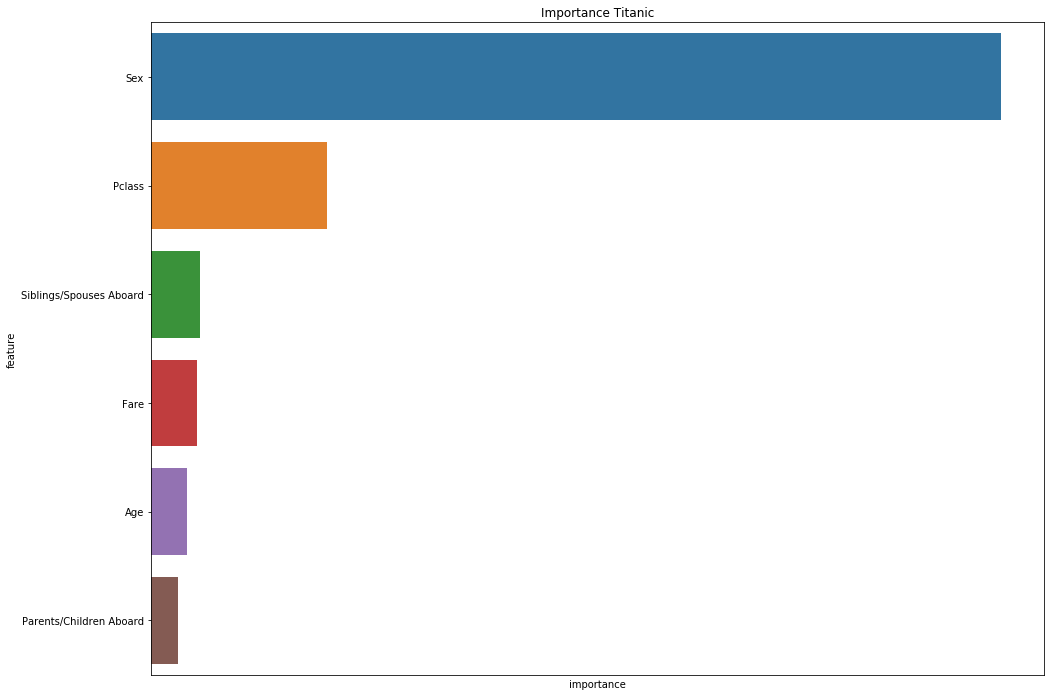

In [31]:
plot_feature_importance(feature_importance, title = 'Importance Titanic')